<a href="https://colab.research.google.com/github/TAUforPython/fuzzy/blob/main/fuzzy%20kNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a simple code for the Minkowski distance-based fuzzy k-nearest neighbor regression (Md-FKNNreg), fuzzy k-nearest neighbor regression (FKNNreg), and k-nearest neighbor regression (KNNreg) models based on the article:


> Kumbure, M.M. and Luukka, P. A generalized fuzzy k-nearest neighbor regression model based on Minkowski distance. Granular Computing, 7, 657–671 (2022). https://doi.org/10.1007/s41066-021-00288-w


Md-FKNNreg function
INPUTS:
    # xtrain: train data is a n-by-m data matrix consisting of n patterns and m features(variables)
    # ytrain: n-dimensional output vector of Xtrain data
    # xtest: Test data is a D-by-m data matrix consisting of D patterns and m features
    # ytest: D-dimensional output vector of Xtest data
    # K: Number of nearest neighbors to be selected
    # p: parameter value of the Minkowski distance, p=2 is for the Euclidean distance

OUTPUT:
    # predicted: Predicted y values for each test pattern in xtest

In [1]:
import numpy as np
import pandas as pd
from math import sqrt

In [2]:

# calculate the Minkowski distance (when p=2 we can apply the Euclidean distance) --> use p=2 for KNNreg, FKNNreg
def minkowski_distance(a, b, p):
	return sum(abs(e1-e2)**p for e1, e2 in zip(a,b))**(1/p)

# find the most similar neighbors
def get_neighbors(xtrain, ytrain, test_sample, K, p):
	distances = list()
	for t in range(len(xtrain)):
		dist  = minkowski_distance(test_sample, xtrain[t], p)
		distances.append((ytrain[t], dist))
	distances.sort(key=lambda tup: tup[1])
	neighbors = list()
	for i in range(K):
		neighbors.append(distances[i]) # neighbors[0]=y values of neighbors, neighbors[1]=distances
	return neighbors

# calculate fuzzy memberships for the neighbors
def get_memberships(neighbors):
    m = 2
    memberships = list()
    for neighbor in neighbors:
        if neighbor[1] == 0:
            memberships.append(0)
        else:
            memberships.append(neighbor[1]**(-1/(m-1)))
    return(memberships)

# calculate fuzzy weighted average of the outputs of the nearest neighbors (i.e., prediction)
def get_prediction(memberships, neighbors):
    train_y = list()
    for neighbor in neighbors:
        train_y.append(neighbor[0])
    products      = [a * b for a, b in zip(memberships, train_y)]
    predicted_val = sum(products)/sum(memberships)
    return predicted_val


# Functions for the nearest neighbor regression methods
#...............................................................................................................
# Minkowski distance-based Fuzzy k-nearest neighbor regression (Md-FKNNreg) function:
def Md_FKNNreg(xtrain, ytrain, xtest, K, p):
    yhat_mdfknn = list()
    for test_sample in xtest:
        mdfknn_neighbors  = get_neighbors(xtrain, ytrain, test_sample, K, p)
        mem_mdfknn        = get_memberships(mdfknn_neighbors)
        mdfknn_prediction = get_prediction(mem_mdfknn, mdfknn_neighbors)
        yhat_mdfknn.append(mdfknn_prediction)
    return yhat_mdfknn


# Fuzzy k-nearest neighbor regression (FKNNreg) function:
def FKNNreg(xtrain, ytrain, xtest, K, p=2):
    yhat_fknn = list()
    for test_sample in xtest:
        fknn_neighbors   = get_neighbors(xtrain, ytrain, test_sample, K, p)
        fknn_memberships = get_memberships(fknn_neighbors)
        fknn_preidiction = get_prediction(fknn_memberships,fknn_neighbors)
        yhat_fknn.append(fknn_preidiction)
    return yhat_fknn


# K-nearest neighbor regression (KNNreg) function:
def KNNreg(xtrain, ytrain, xtest, K, p=2):
    yhat_knn = list()
    for test_sample in xtest:
        knn_neighbors      = get_neighbors(xtrain, ytrain, test_sample, K, p)
        knn_memberships    = np.ones(K)
        knn_preidiction    = get_prediction(knn_memberships,knn_neighbors)
        yhat_knn.append(knn_preidiction)
    return yhat_knn



1. Cement (component 1)(kg in a m^3 mixture)
2. Blast Furnace Slag (component 2)(kg in a m^3 mixture)
3. Fly Ash (component 3)(kg in a m^3 mixture)
4. Water  (component 4)(kg in a m^3 mixture)
5. Superplasticizer (component 5)(kg in a m^3 mixture)
6. Coarse Aggregate  (component 6)(kg in a m^3 mixture)
7. Fine Aggregate (component 7)(kg in a m^3 mixture)
8. Age (day)
9. Concrete compressive strength(MPa, megapascals)
10. Type (1, 2 or 3)

In [29]:
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

# import simple data set to test the FKNNreg model
#data    = pd.read_csv ('qsar_fish_toxicity.csv', sep = ';')
#data    = pd.read_csv ('ConcreteData.csv', sep = ';') # from GitHub repository
url = 'https://raw.githubusercontent.com/TAUforPython/fuzzy/main/ConcreteData.csv'
data = pd.read_csv(url, sep = ';')
sc_data = normalize(data) # data scaling

X = sc_data[:, 0:-1] # features set
y = sc_data[:, -1]   # set of study variable

# split the data into training and test with a 80/20 split
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.20)

In [30]:
data

,Cement,Blast,FlyAsh,Water,Superplasticizer,Coarse,Fine,Age,Strength,Type
0,230.0,0.0,118.3,195.5,4.6,1029.4,758.6,3,10.03,1
1,116.0,173.0,0.0,192.0,0.0,909.8,891.9,7,10.09,1
2,255.0,0.0,0.0,192.0,0.0,889.8,945.0,7,10.22,1
3,238.1,0.0,0.0,185.7,0.0,1118.8,789.3,7,10.34,1
4,122.6,183.9,0.0,203.5,0.0,958.2,800.1,7,10.35,1
...,...,...,...,...,...,...,...,...,...,...
1025,155.0,0.0,143.0,193.0,9.0,877.0,868.0,28,9.74,1
1026,154.8,0.0,142.8,193.3,9.1,877.2,867.7,28,9.74,1
1027,202.0,11.0,141.0,206.0,1.7,942.0,801.0,3,9.85,1
1028,310.0,0.0,0.0,192.0,0.0,971.0,850.6,3,9.87,1


In [31]:
import matplotlib.pyplot as plt

<Axes: >

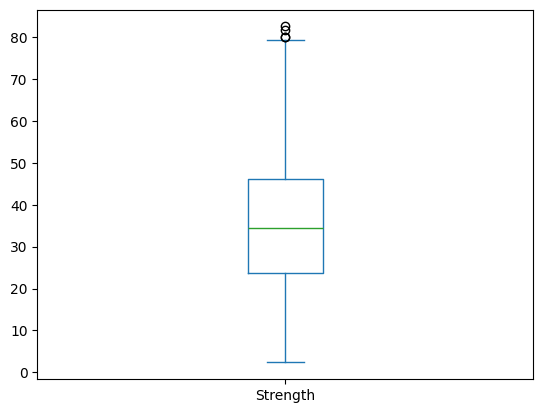

In [32]:
data['Strength'].plot(kind = 'box')

<Axes: >

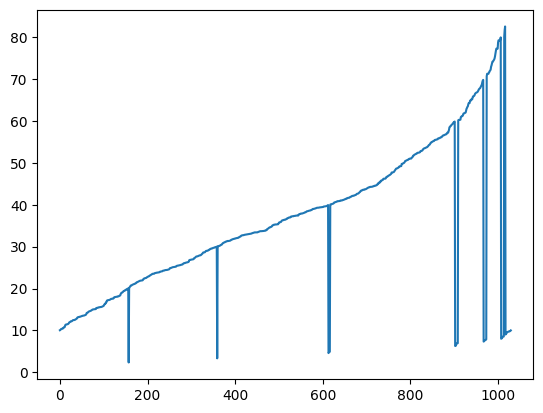

In [33]:
data['Strength'].plot()

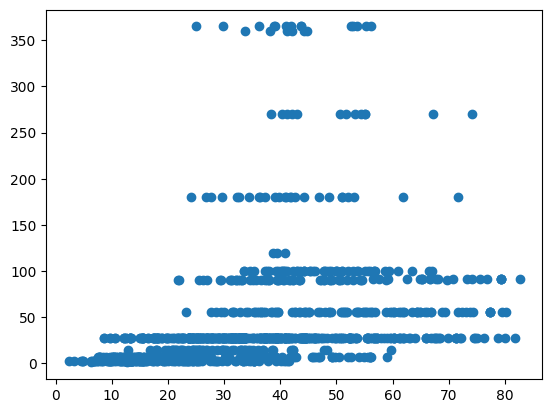

In [34]:
plt.plot(data['Strength'],data['Age'],'o')

<Axes: >

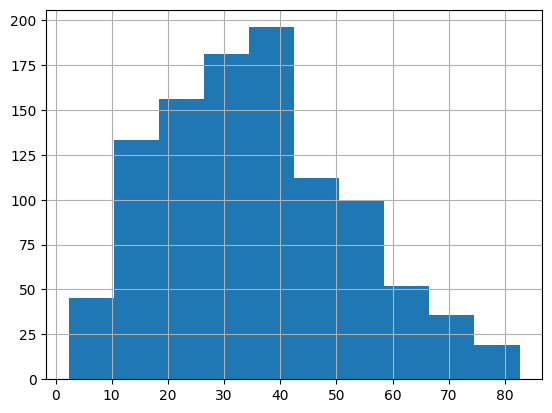

In [35]:
data['Strength'].hist(bins = 10)

In [36]:
import seaborn as sns

https://realpython.com/knn-python/

In [37]:
data.columns

Index(['Cement', 'Blast', 'FlyAsh', 'Water', 'Superplasticizer', 'Coarse',
       'Fine', 'Age', 'Strength', 'Type'],
      dtype='object')

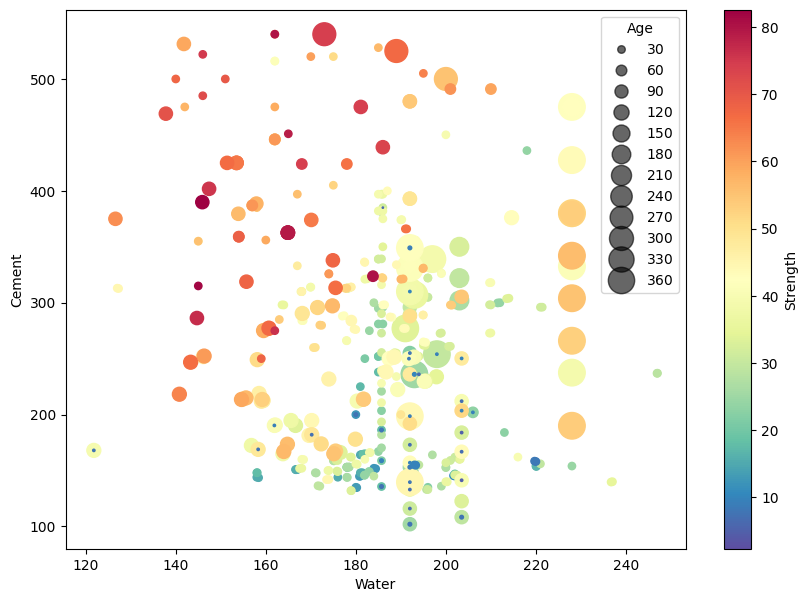

In [38]:
cmap = sns.color_palette("Spectral", as_cmap=True).reversed()
f, ax = plt.subplots(figsize = (10,7))
Xaxis = data['Water']
Yaxis = data['Cement']
Color = data['Strength']
Area = data['Age']

points = ax.scatter(Xaxis, Yaxis, Area, Color, cmap=cmap)
f.colorbar(points, label = data.columns[8])
plt.xlabel(data.columns[3])
plt.ylabel(data.columns[0])

handles, labels = points.legend_elements(prop="sizes", alpha=0.6)
ax.legend(handles, labels, loc="upper right", title=data.columns[7])

plt.show()

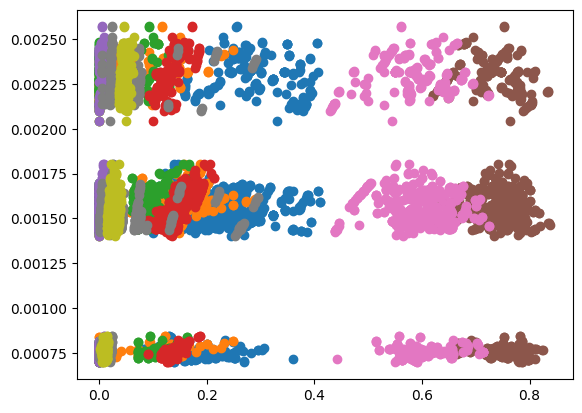

In [39]:
plt.plot(X,y,'o')
plt.show()

In [53]:
K      = 10 # define the number of nearest neighbors


#----------- Run the nearest neighbor regression methods---------

# Md-FKNNreg
p = 2 # one can run Md_FKNNreg method for different values of p
yhat_mdfknn = Md_FKNNreg(xtrain, ytrain, xtest, K, p)

# FKNNreg
yhat_fknn   = FKNNreg(xtrain, ytrain, xtest, K)

# KNNreg
yhat_knn    = KNNreg(xtrain, ytrain, xtest, K)


# Accuracy measures - Md-FKNNreg
mse_f1  = np.mean((ytest - yhat_mdfknn)**2) # mean square error
rmse_f1 = np.sqrt(mse_f1) # root mean square error
r2_f1   = 1-(sum((ytest - yhat_mdfknn)**2)/sum((ytest-np.mean(ytest))**2)) # R2 value

# Accuracy measures - FKNNreg
mse_f2  = np.mean((ytest - yhat_fknn)**2)
rmse_f2 = np.sqrt(mse_f2)
r2_f2   = 1-(sum((ytest - yhat_fknn)**2)/sum((ytest-np.mean(ytest))**2))

# Accuracy measures - KNNreg
mse_f3  = np.mean((ytest - yhat_knn)**2)
rmse_f3 = np.sqrt(mse_f3)
r2_f3   = 1-(sum((ytest - yhat_knn)**2)/sum((ytest-np.mean(ytest))**2))

# print the results
print("Md-FKNNreg Results:")
print("MSE:", mse_f1)
print("RMSE:", rmse_f1)
print("R-Squared:", r2_f1)
print(" ")

print("FKNNreg Results:")
print("MSE:", mse_f2)
print("RMSE:", rmse_f2)
print("R-Squared:", r2_f2)
print(" ")

print("KNNreg Results:")
print("MSE:", mse_f3)
print("RMSE:", rmse_f3)
print("R-Squared:", r2_f3)

Md-FKNNreg Results:
MSE: 6.790352574237186e-08
RMSE: 0.0002605830496067844
R-Squared: 0.6920611350559216
 
FKNNreg Results:
MSE: 6.790352574237186e-08
RMSE: 0.0002605830496067844
R-Squared: 0.6920611350559216
 
KNNreg Results:
MSE: 8.67964380244347e-08
RMSE: 0.00029461235212467705
R-Squared: 0.6063827862511832


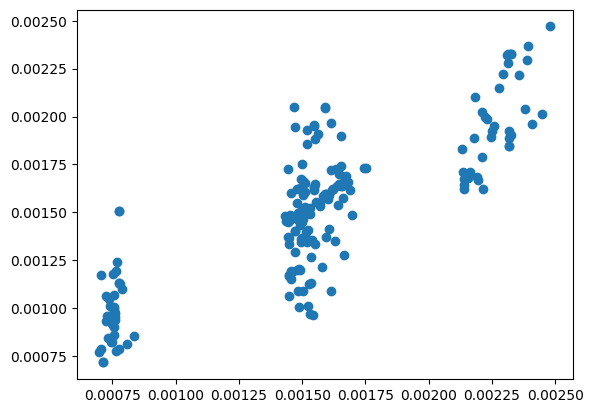

In [54]:
plt.plot(ytest, yhat_fknn, 'o')

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, neighbors
from matplotlib.colors import ListedColormap

In [56]:
XX = [data['Water'], data['Cement']]
yy = data['Type']

X = np.transpose(np.array(list(XX)))
y = np.transpose(np.array(list(yy)))

In [58]:
k = 10
knn = neighbors.KNeighborsClassifier(k, metric='euclidean')
knn.fit(X, y)

KNeighborsClassifier(metric='euclidean', n_neighbors=10)

In [59]:
h = 5
cmap_light = ListedColormap(['orange', 'cyan', 'green'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [60]:
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

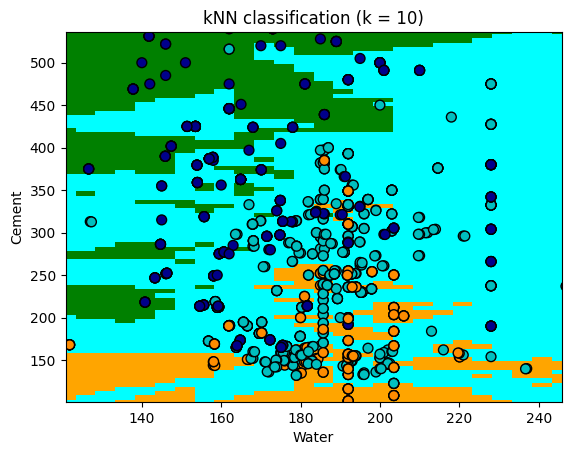

In [61]:
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=50)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel(data.columns[3])
plt.ylabel(data.columns[0])
plt.title("kNN classification (k = %i)" % k)
plt.show()

# Visualisation

Md-FKNNreg Results:
MSE: 6.745478087024664e-08
RMSE: 0.00025972058229999144
R-Squared: 0.7396390902028307

FKNNreg Results:
MSE: 6.745478087024664e-08
RMSE: 0.00025972058229999144
R-Squared: 0.7396390902028307

KNNreg Results:
MSE: 9.617592022208344e-08
RMSE: 0.0003101224277959971
R-Squared: 0.6287816850555271



Text(0.5, 1.0, 'Confusion Matrix: KNNreg (Strength Binned)')

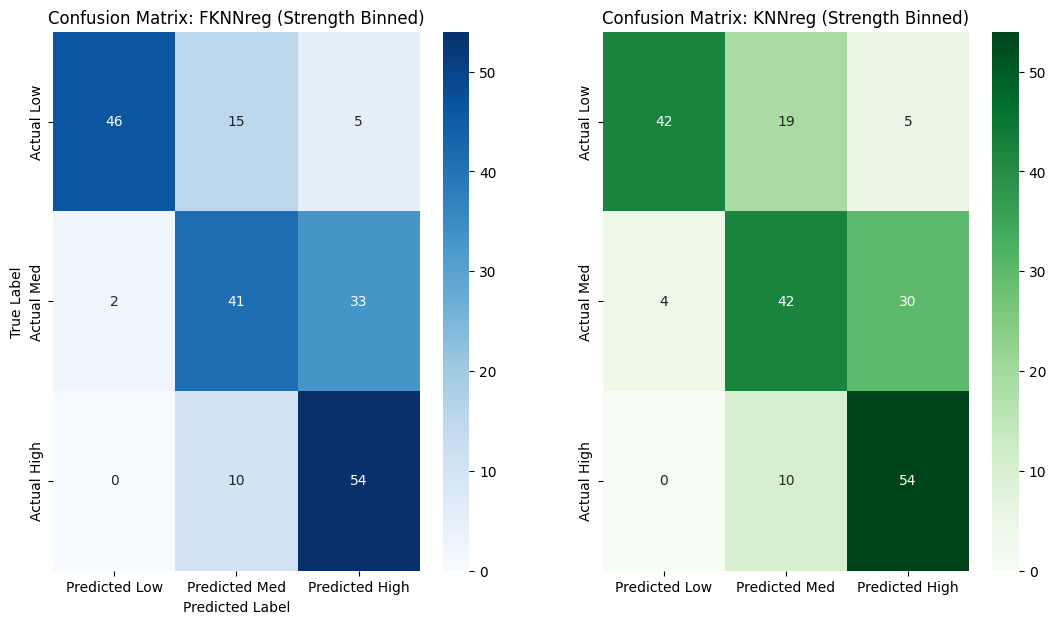

In [71]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor # For comparison with sklearn's KNN
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Assuming the provided functions (minkowski_distance, get_neighbors, etc.)
#     and data loading/preprocessing steps are executed here ---
# (Code for functions and data loading as provided in the snippet)
url = 'https://raw.githubusercontent.com/TAUforPython/fuzzy/main/ConcreteData.csv'
data = pd.read_csv(url, sep=';')
# Use original data for binning later, scaled data for the models
original_strength = data['Strength'].values # Keep original scale for binning
sc_data = normalize(data)
X = sc_data[:, 0:-1]
y = sc_data[:, -1]
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=42) # Added random_state for reproducibility

# --- Model Execution ---
K = 10

# Run the regression methods
yhat_mdfknn = Md_FKNNreg(xtrain, ytrain, xtest, K, p=2) # Note: p=2 specified explicitly
yhat_fknn = FKNNreg(xtrain, ytrain, xtest, K) # Uses p=2 internally by default
yhat_knn = KNNreg(xtrain, ytrain, xtest, K) # Uses p=2 internally by default

# --- Accuracy Measures ---
# Md-FKNNreg
mse_f1 = mean_squared_error(ytest, yhat_mdfknn)
rmse_f1 = np.sqrt(mse_f1)
r2_f1 = r2_score(ytest, yhat_mdfknn)

# FKNNreg
mse_f2 = mean_squared_error(ytest, yhat_fknn)
rmse_f2 = np.sqrt(mse_f2)
r2_f2 = r2_score(ytest, yhat_fknn)

# KNNreg
mse_f3 = mean_squared_error(ytest, yhat_knn)
rmse_f3 = np.sqrt(mse_f3)
r2_f3 = r2_score(ytest, yhat_knn)

# Print results (as in original)
print("Md-FKNNreg Results:")
print("MSE:", mse_f1)
print("RMSE:", rmse_f1)
print("R-Squared:", r2_f1)
print("")
print("FKNNreg Results:")
print("MSE:", mse_f2)
print("RMSE:", rmse_f2)
print("R-Squared:", r2_f2)
print("")
print("KNNreg Results:")
print("MSE:", mse_f3)
print("RMSE:", rmse_f3)
print("R-Squared:", r2_f3)
print("")


# --- Addition: Confusion Matrices for KNN and FKNN (using Discretization) ---

# Determine bin edges based on the ORIGINAL (unscaled) strength values for meaningful categories
# Let's use percentiles for robust binning
p33 = np.percentile(original_strength, 33)
p66 = np.percentile(original_strength, 66)
strength_bins = [-np.inf, p33, p66, np.inf]
strength_labels = ['Low', 'Medium', 'High']

# Function to discretize scaled values back based on original distribution bins
# Find indices for train/test split matching the original order (assuming default shuffle=False in train_test_split is not used)
# Since we used random_state, we need to get the indices used by train_test_split
# It's simpler to re-split the original_strength using the same parameters to get corresponding y values
_, _, ytrain_orig, ytest_orig = train_test_split(data.drop('Strength', axis=1).values, original_strength, test_size=0.20, random_state=42)

# Discretize the ORIGINAL test strengths and predictions
ytest_binned = np.digitize(ytest_orig, strength_bins, right=False) - 1 # Convert to 0-based index
ytest_binned_labels = [strength_labels[i] if i < len(strength_labels) else strength_labels[-1] for i in ytest_binned]

yhat_fknn_np = np.array(yhat_fknn)
# Map scaled predictions back to approximate original scale for binning
# We need the scaling factor applied to 'Strength'. Assuming last column was scaled independently:
# Find the min and max of the original strength to reverse the normalization if needed,
# but scikit-learn's normalize function normalizes each row, not column-wise scaling.
# The provided code uses sklearn.preprocessing.normalize which normalizes samples (rows), not features (columns).
# This changes the nature of the problem significantly and makes reversing the scaling complex and often incorrect
# for individual features or targets post-normalization.
# Let's assume the y (scaled Strength) corresponds directly to normalized values of the original Strength column.
# To bin predictions meaningfully, we should ideally scale them back.
# However, with row-wise normalization, exact reversal isn't straightforward without storing the norms.
# For demonstration, let's assume the scaling was roughly min-max or standardization applied to the 'Strength' column itself.
# Since we don't have that scaler, we'll approximate by mapping the scaled prediction range to the original strength range.
# Get the range of original strength values in the test set
orig_strength_min = np.min(ytest_orig)
orig_strength_max = np.max(ytest_orig)
# Get the range of scaled strength values in the test set (ytest contains scaled true values)
scaled_strength_min = np.min(ytest)
scaled_strength_max = np.max(ytest)

# Function to map scaled values back to an approximate original range for binning
def map_scaled_to_orig(scaled_vals, orig_min, orig_max, scaled_min, scaled_max):
    # Handle potential division by zero if all scaled vals are the same (unlikely in a diverse dataset)
    if scaled_max - scaled_min == 0:
        return np.full_like(scaled_vals, orig_min)
    # Linear mapping
    return orig_min + (scaled_vals - scaled_min) * (orig_max - orig_min) / (scaled_max - scaled_min)

# Map predictions back to original-like scale for binning
yhat_fknn_orig_like = map_scaled_to_orig(yhat_fknn_np, orig_strength_min, orig_strength_max, scaled_strength_min, scaled_strength_max)
yhat_knn_orig_like = map_scaled_to_orig(np.array(yhat_knn), orig_strength_min, orig_strength_max, scaled_strength_min, scaled_strength_max)

# Now discretize the mapped predictions
yhat_fknn_binned = np.digitize(yhat_fknn_orig_like, strength_bins, right=False) - 1
yhat_fknn_binned_labels = [strength_labels[i] if i < len(strength_labels) else strength_labels[-1] for i in yhat_fknn_binned]

yhat_knn_binned = np.digitize(yhat_knn_orig_like, strength_bins, right=False) - 1
yhat_knn_binned_labels = [strength_labels[i] if i < len(strength_labels) else strength_labels[-1] for i in yhat_knn_binned]


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))

# Create and plot Confusion Matrix for FKNN
cm_fknn = confusion_matrix(ytest_binned_labels, yhat_fknn_binned_labels, labels=strength_labels)
sns.heatmap(cm_fknn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Low', 'Predicted Med', 'Predicted High'],
            yticklabels=['Actual Low', 'Actual Med', 'Actual High'],
            ax = ax[0])
ax[0].set_title('Confusion Matrix: FKNNreg (Strength Binned)')
ax[0].set_ylabel('True Label')
ax[0].set_xlabel('Predicted Label')
#plt.show()

# Create and plot Confusion Matrix for KNN
cm_knn = confusion_matrix(ytest_binned_labels, yhat_knn_binned_labels, labels=strength_labels)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted Low', 'Predicted Med', 'Predicted High'],
            yticklabels=['Actual Low', 'Actual Med', 'Actual High'],
            ax=ax[1])
ax[1].set_title('Confusion Matrix: KNNreg (Strength Binned)')
#ax[1].ylabel('True Label')
#ax[1].xlabel('Predicted Label')
#plt.show()
